1. **Import Necessary Libraries**

    - Import libraries for file operations (`os`), image processing (`cv2`), numerical computations (`numpy`), and random number generation (`random`).
    - Use `xml.etree.ElementTree` for XML parsing and `Faker` for generating synthetic data with UK locale.
    - Load `pandas` for data manipulation, `easyocr` for OCR, and `LabelEncoder` for preprocessing.
    - Import TensorFlow/Keras libraries for building deep learning models (`Sequential`, `Embedding`, `LSTM`, `Dense`, `Dropout`, `Conv1D`, `MaxPooling1D`).
    - Utilize `Tokenizer` and `pad_sequences` for text preprocessing.
    - Use `joblib` for model serialization and `load_model` for loading Keras models.
    - Use `tkinter` for creating a graphical user interface (GUI) with file dialog support.
    - Use `PIL` and `ImageTk` for image handling within the GUI.
    - Import `matplotlib` for plotting and `sklearn.metrics` for evaluating model performance (accuracy, precision, recall, F1-score).
    - Implement `EarlyStopping` to prevent overfitting during model training.


In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import random
import xml.etree.ElementTree as ET
from faker import Faker
import pandas as pd
import easyocr
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib
from tensorflow.keras.models import load_model
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping


# Initialize Faker with UK locale
fake = Faker('en_GB')  # Use the UK locale for Faker


2. **Create Directories for Datasets**

    - Create necessary directories for organizing the dataset, including separate folders for training images, training labels, validation images, and validation labels.
    - Use `os.makedirs` with `exist_ok=True` to ensure the directories are created only if they don't already exist, preventing any errors if they do.


In [2]:
# Create directories for datasets
os.makedirs('data/train/images', exist_ok=True)
os.makedirs('data/train/labels', exist_ok=True)
os.makedirs('data/val/images', exist_ok=True)
os.makedirs('data/val/labels', exist_ok=True)


3. **Define Types of PII and Generation Functions**

    - Define a list of personally identifiable information (PII) types such as `Name`, `Phone`, `Email`, `Passport`, `DriverLicense`, and `PostalCode`.
    - Implement functions to generate UK-specific PII using the `Faker` library:
        - `generate_uk_phone_number`: Generates a UK phone number.
        - `generate_uk_email`: Generates a UK email address.
        - `generate_uk_passport_number`: Generates a UK passport number.
        - `generate_uk_driver_license`: Generates a UK driver’s license number.
        - `generate_uk_postcode`: Generates a UK postcode.
        - `generate_uk_name`: Generates a UK name.
    - Store these functions in a list called `pii_funcs` for easy access and execution.


In [3]:
# Define types of PII
pii_types = ['Name', 'Phone', 'Email', 'Passport', 'DriverLicense', 'PostalCode']

# Define functions to generate UK-specific PII
def generate_uk_phone_number():
    return fake.phone_number()

def generate_uk_email():
    return fake.email()

def generate_uk_passport_number():
    return fake.bothify(text='########')

def generate_uk_driver_license():
    return fake.bothify(text='??????????')

def generate_uk_postcode():
    return fake.postcode()

def generate_uk_name():
    return fake.name()

pii_funcs = [
    generate_uk_name,
    generate_uk_phone_number,
    generate_uk_email,
    generate_uk_passport_number,
    generate_uk_driver_license,
    generate_uk_postcode
]


4. **Create Image with PII and Annotate**

    - Define a function `create_image_with_pii` that generates an image with randomly placed personally identifiable information (PII) and saves corresponding annotations.
    - Start by creating a blank white image of size 500x800 pixels using `numpy`.
    - Implement a helper function `check_overlap` to ensure that newly placed text does not overlap with existing text on the image.
    - For each PII type, generate corresponding text using predefined functions (`pii_funcs`), and place the text at a random, non-overlapping position on the image.
    - Draw the text on the image in black color using `cv2.putText`, with random font scale and thickness for variability.
    - Save the generated image to the specified `image_path`.
    - Create an XML file to store annotations, including the PII type, text content, and bounding box coordinates. This annotation file is saved to the specified `label_path`.


In [4]:
def create_image_with_pii(image_path, label_path):
    # Create a blank image with a white background
    image = np.ones((500, 800, 3), dtype=np.uint8) * 255
    
    annotations = []
    used_bboxes = []

    def check_overlap(new_bbox):
        for bbox in used_bboxes:
            if (new_bbox[0] < bbox[2] and new_bbox[2] > bbox[0] and
                new_bbox[1] < bbox[3] and new_bbox[3] > bbox[1]):
                return True
        return False

    for i, pii_func in enumerate(pii_funcs):
        text = pii_func()
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = random.uniform(0.8, 1.2)  # Random font scale
        thickness = random.randint(1, 2)  # Random thickness

        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        attempts = 0
        while attempts < 100:  # Try 100 times to find a non-overlapping position
            text_x = random.randint(0, image.shape[1] - text_size[0])
            text_y = random.randint(text_size[1], image.shape[0] - text_size[1])
            new_bbox = [text_x, text_y - text_size[1], text_x + text_size[0], text_y]
            
            if not check_overlap(new_bbox):
                used_bboxes.append(new_bbox)
                break
            attempts += 1
        
        if attempts == 100:
            print(f"Could not find non-overlapping position: {text}")
            continue

        # Use black color for text to ensure visibility
        color = (0, 0, 0)
        # Draw text
        cv2.putText(image, text, (text_x, text_y), font, font_scale, color, thickness)

        annotations.append((pii_types[i], text, new_bbox))

    # Save the image
    cv2.imwrite(image_path, image)

    # Save the annotation file
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'folder').text = 'images'
    ET.SubElement(annotation, 'filename').text = os.path.basename(image_path)
    ET.SubElement(annotation, 'path').text = os.path.abspath(image_path)
    
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(image.shape[1])
    ET.SubElement(size, 'height').text = str(image.shape[0])
    ET.SubElement(size, 'depth').text = str(image.shape[2])

    for (pii_type, text, bbox) in annotations:
        obj = ET.SubElement(annotation, 'object')
        ET.SubElement(obj, 'name').text = pii_type
        ET.SubElement(obj, 'text').text = text  # Add text content
        bndbox = ET.SubElement(obj, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(bbox[0])
        ET.SubElement(bndbox, 'ymin').text = str(bbox[1])
        ET.SubElement(bndbox, 'xmax').text = str(bbox[2])
        ET.SubElement(bndbox, 'ymax').text = str(bbox[3])

    tree = ET.ElementTree(annotation)
    tree.write(label_path)


5. **Generate Training and Validation Sets**

    - Define the number of images for training (`num_train = 1000`) and validation (`num_val = 200`) datasets.
    - Loop through the specified number of training examples, generating images with PII and corresponding annotation files. Save them in the `data/train/images` and `data/train/labels` directories, respectively.
    - Similarly, loop through the specified number of validation examples, generating and saving them in the `data/val/images` and `data/val/labels` directories.
    - Use the previously defined `create_image_with_pii` function to generate each image and its associated annotation.


In [5]:
# Generate training and validation sets
num_train = 1000
num_val = 200

for i in range(num_train):
    image_path = f'data/train/images/img_{i}.jpg'
    label_path = f'data/train/labels/img_{i}.xml'
    create_image_with_pii(image_path, label_path)

for i in range(num_val):
    image_path = f'data/val/images/img_{i}.jpg'
    label_path = f'data/val/labels/img_{i}.xml'
    create_image_with_pii(image_path, label_path)


6. **Initialize OCR and Extract Labeled Texts**

    - Initialize an EasyOCR reader with English (`'en'`) as the target language.
    - Define a function `ocr_image` that takes an image path, uses the OCR reader to extract text from the image, and returns the OCR results.
    - Implement the `extract_labeled_texts` function to process images and their corresponding annotation files:
        - Iterate over all image files in the specified directory.
        - For each image, use the `ocr_image` function to extract text.
        - Parse the corresponding XML annotation file to retrieve labeled text data.
        - Compare the OCR results with the labeled text, and if a match is found, store the text and its label in a list.
        - Return the collected data as a `pandas.DataFrame` for further analysis or processing.


In [6]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

def ocr_image(image_path):
    ocr_result = reader.readtext(image_path, detail=0)
    return ocr_result

def extract_labeled_texts(image_dir, label_dir):
    data = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, filename.replace('.jpg', '.xml'))
            
            # Use OCR tool to extract text
            ocr_result = ocr_image(image_path)
            print(f"OCR Result: {ocr_result}")  # Print OCR result for debugging

            # Read annotation file
            tree = ET.parse(label_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                name = obj.find('name').text
                text = obj.find('text').text
                for ocr_text in ocr_result:
                    if ocr_text and ocr_text == text:
                        data.append({'text': ocr_text, 'label': name})
                        print(f"Matched text: {ocr_text}, Label: {name}")  # Print matched text and label for debugging

    return pd.DataFrame(data)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


7. **Create Training and Validation Datasets**

    - Use the `extract_labeled_texts` function to generate datasets from the training and validation images:
        - `train_df`: Extract labeled texts from the training images and annotations located in `data/train/images` and `data/train/labels`, respectively.
        - `val_df`: Extract labeled texts from the validation images and annotations located in `data/val/images` and `data/val/labels`.
    - The resulting datasets (`train_df` and `val_df`) are stored as `pandas.DataFrame` objects for use in training and evaluating machine learning models.


In [7]:
# Create training and validation datasets
train_df = extract_labeled_texts('data/train/images', 'data/train/labels')
val_df = extract_labeled_texts('data/val/images', 'data/val/labels')


OCR Result: ['+44808', '1570060', '20014904', 'Ms', 'Janice Williams', 'telFnugTFD', 'KTS 3PP', 'nicholasbirch@example net']
Matched text: 20014904, Label: Passport
Matched text: telFnugTFD, Label: DriverLicense
OCR Result: ['Marc', 'Clark', '92142109', '+44(0)1214960047', 'esimpson', 'example org', 'MrHGGcaHSe', 'S03', '1TT']
Matched text: +44(0)1214960047, Label: Phone
Matched text: 92142109, Label: Passport
Matched text: MrHGGcaHSe, Label: DriverLicense
OCR Result: ['09722490', 'uzHLQFSOYM', '+44(0)116 4960285', 'clarkealbert@example.com', 'Ms Irene Ryan', 'BNSN', '7EY']
Matched text: Ms Irene Ryan, Label: Name
Matched text: +44(0)116 4960285, Label: Phone
Matched text: clarkealbert@example.com, Label: Email
Matched text: 09722490, Label: Passport
Matched text: uzHLQFSOYM, Label: DriverLicense
OCR Result: ['malcolmallen@example net', '90799353 4LG', '(0151) 496 0446', 'Phillip Wallace', 'HOCxAGQPIR']
Matched text: Phillip Wallace, Label: Name
Matched text: (0151) 496 0446, Label: Ph

8. **Check for Required Labels in Datasets**

    - Define a list of `required_labels` that should be present in the datasets, including `Name`, `Phone`, `Email`, `Passport`, `DriverLicense`, and `PostalCode`.
    - Implement the `check_labels` function to verify that all required labels are present in the dataset:
        - Extract the unique labels from the dataset.
        - For each required label, check if it is present in the dataset:
            - Print a warning if any required label is missing.
            - Confirm the presence of each required label with a message.
    - Apply the `check_labels` function to both the training (`train_df`) and validation (`val_df`) datasets to ensure they contain all necessary labels.


In [8]:
# Check if the data contains all required labels
required_labels = ['Name', 'Phone', 'Email', 'Passport', 'DriverLicense', 'PostalCode']

def check_labels(df, required_labels):
    labels_in_data = df['label'].unique()
    for label in required_labels:
        if label not in labels_in_data:
            print(f"Warning: Missing label in dataset: {label}")
        else:
            print(f"Label {label} is present in the dataset")

check_labels(train_df, required_labels)
check_labels(val_df, required_labels)


Label Name is present in the dataset
Label Phone is present in the dataset
Label Email is present in the dataset
Label Passport is present in the dataset
Label DriverLicense is present in the dataset
Label PostalCode is present in the dataset
Label Name is present in the dataset
Label Phone is present in the dataset
Label Email is present in the dataset
Label Passport is present in the dataset
Label DriverLicense is present in the dataset
Label PostalCode is present in the dataset


9. **Text Preprocessing, Model Training, and Saving**

    - **Text Preprocessing:**
        - Initialize a `Tokenizer` with a vocabulary size of 10,000 and an out-of-vocabulary token (`<OOV>`).
        - Fit the tokenizer on the training dataset's text and create a `preprocess_text` function to convert texts into sequences and pad them to a maximum length of 100.
        - Apply this preprocessing to both the training (`X_train`) and validation (`X_val`) text data.

    - **Label Encoding:**
        - Use `LabelEncoder` to convert the categorical labels into numerical format.
        - Fit the encoder on the training labels (`y_train`) and transform the validation labels (`y_val`).

    - **Model Training:**
        - Define a sequential deep learning model using Keras, which includes:
            - An embedding layer for converting text input into dense vectors.
            - A convolutional layer (`Conv1D`) followed by a max-pooling layer (`MaxPooling1D`) for feature extraction.
            - An LSTM layer for capturing sequential dependencies.
            - A dense layer and a dropout layer to prevent overfitting.
            - A final output layer with softmax activation for multi-class classification.
        - Compile the model with `sparse_categorical_crossentropy` loss and `adam` optimizer, and train it on the preprocessed training data, validating against the validation data.

    - **Model and Preprocessor Saving:**
        - Save the trained model to a file (`pii_model.h5`).
        - Serialize and save the `Tokenizer` and `LabelEncoder` objects using `joblib` for future use.


In [9]:
# Text preprocessing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'].values)

def preprocess_text(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=100)
    return padded_sequences

X_train = preprocess_text(train_df['text'].values)
X_val = preprocess_text(val_df['text'].values)

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'].values)
y_val = label_encoder.transform(val_df['label'].values)

# Model training
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),  
    Conv1D(256, 5, padding='same', activation='relu'),  
    MaxPooling1D(pool_size=2),
    LSTM(128),  
    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(len(set(train_df['label'])), activation='softmax') 
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))  

# Save the model and preprocessors
model.save('pii_model.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


Epoch 1/10


c:\Users\r0g3r\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3208 - loss: 1.6144 - val_accuracy: 0.6424 - val_loss: 0.8560
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6328 - loss: 0.8199 - val_accuracy: 0.7087 - val_loss: 0.6126
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7493 - loss: 0.5205 - val_accuracy: 0.6327 - val_loss: 0.7588
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9127 - loss: 0.2495 - val_accuracy: 0.6327 - val_loss: 1.7247
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9864 - loss: 0.0569 - val_accuracy: 0.6327 - val_loss: 2.2259
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9999 - loss: 0.0106 - val_accuracy: 0.6327 - val_loss: 2.8086
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.6327 - val_loss: 3.1641
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.6327 - val_loss: 3.

['label_encoder.pkl']

10. **Load Model, Preprocessors, and Implement Prediction Functions**

    - **Model and Preprocessors Loading:**
        - Load the trained deep learning model (`pii_model.h5`) and the corresponding `Tokenizer` and `LabelEncoder` objects using `load_model` and `joblib.load`, respectively.
    
    - **OCR and Prediction Functions:**
        - Reinitialize the EasyOCR reader for text extraction from images.
        - Define `predict_pii`, a function that preprocesses text inputs, predicts their PII type using the loaded model, and returns the predicted labels.
        - Implement `ocr_image`, which uses EasyOCR to extract and merge adjacent text boxes from an image for better accuracy. It includes helper functions:
            - `is_adjacent`: Determines if two bounding boxes are adjacent.
            - `merge_bboxes`: Merges two adjacent bounding boxes into one.
        - Define `draw_boxes`, a function that overlays bounding boxes and labels on the image based on OCR results and predicted labels. The bounding boxes are color-coded according to the PII type:
            - `Name` and `Email`: Yellow
            - `Phone` and `PostalCode`: Blue
            - `Passport` and `DriverLicense`: Red
            - Default: Green
        - The function draws rectangles around detected text regions and places the corresponding PII labels above them.


In [10]:
# Load the model and preprocessors
model = load_model('pii_model.h5')
tokenizer = joblib.load('tokenizer.pkl')
label_encoder = joblib.load('label_encoder.pkl')

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])


def predict_pii(texts):
    """Predict the PII type for a list of texts using the trained model."""
    seqs = tokenizer.texts_to_sequences(texts)
    padded_seqs = pad_sequences(seqs, maxlen=100)
    preds = model.predict(padded_seqs)
    labels = label_encoder.inverse_transform(np.argmax(preds, axis=1))
    return labels

def ocr_image(image_path):
    results = reader.readtext(image_path, detail=1)
    merged_results = []

    for result in results:
        bbox, text, confidence = result
        if len(merged_results) > 0 and is_adjacent(merged_results[-1][0], bbox):
            merged_results[-1] = (
                merge_bboxes(merged_results[-1][0], bbox),
                merged_results[-1][1] + " " + text,
                min(merged_results[-1][2], confidence)
            )
        else:
            merged_results.append(result)

    return merged_results

def is_adjacent(bbox1, bbox2):
    return abs(bbox1[2][0] - bbox2[0][0]) < 10

def merge_bboxes(bbox1, bbox2):
    x_min = min(bbox1[0][0], bbox2[0][0])
    y_min = min(bbox1[0][1], bbox2[0][1])
    x_max = max(bbox1[2][0], bbox2[2][0])
    y_max = max(bbox1[2][1], bbox2[2][1])
    return [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]]

def draw_boxes(image_path, ocr_results, labels):
    """Draw bounding boxes on the image based on OCR results and labels."""
    image = cv2.imread(image_path)
    color_dict = {
        'Name': (0, 255, 255),  # Yellow
        'Phone': (255, 0, 0),   # Blue
        'Email': (0, 255, 255), # Yellow
        'Passport': (0, 0, 255),# Red
        'DriverLicense': (0, 0, 255), # Red
        'PostalCode': (255, 0, 0)  # Blue
    }
    
    for result, label in zip(ocr_results, labels):
        bbox, text, confidence = result
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))

        # Debug prints
        print("Top left:", top_left)
        print("Bottom right:", bottom_right)
        
        color = color_dict.get(label, (0, 255, 0))  # Default green
        
        # Draw rectangle
        cv2.rectangle(image, top_left, bottom_right, color, 2)
        
        # Draw background rectangle for label
        text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        cv2.rectangle(image, (top_left[0], top_left[1] - 30), (top_left[0] + text_size[0], top_left[1]), color, -1)
        
        # Put text
        cv2.putText(image, label, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 2)
    
    return image



11. **Set Up the Main Application Window**

    - **Initialize the Application Window:**
        - Create the main application window using `tkinter` and set the window title to "PII Detection Tool".
        - Define the window size as 1000x700 pixels.

    - **Function to Process and Display Image:**
        - Implement the `open_image` function that allows the user to select an image file (JPEG or PNG).
        - Once an image is selected:
            - Use `ocr_image` to extract text and `predict_pii` to determine the PII types for the extracted texts.
            - Use `draw_boxes` to overlay the detected text regions and their labels on the image.
            - Convert the processed image from BGR to RGB format and prepare it for display in the Tkinter window.
            - Display the processed image in the Tkinter window.

    - **Create UI Elements:**
        - Add a `Label` widget (`panel`) to the window for displaying the processed image.
        - Add a `Button` widget that triggers the `open_image` function when clicked, allowing the user to load and process an image.

    - **Start the GUI Event Loop:**
        - Begin the Tkinter main event loop (`root.mainloop()`), which keeps the application window open and responsive to user interactions.


In [11]:
# Set up the main application window
root = tk.Tk()
root.title("PII Detection Tool")
root.geometry("1000x700")

# Function to open an image file, process it, and display the results
def open_image():
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
    if file_path:
        ocr_results = ocr_image(file_path)
        texts = [result[1] for result in ocr_results]
        labels = predict_pii(texts)
        processed_image = draw_boxes(file_path, ocr_results, labels)
        
        # Convert image for display in Tkinter
        processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
        processed_image = Image.fromarray(processed_image)
        processed_image.thumbnail((800, 600))
        img = ImageTk.PhotoImage(processed_image)
        
        # Display the image
        panel.config(image=img)
        panel.image = img

# Create UI elements
panel = tk.Label(root)
panel.pack(padx=10, pady=10)

btn = ttk.Button(root, text="Load Image", command=open_image)
btn.pack(pady=20)

# Start the GUI event loop
root.mainloop()


12. **Load Training Data, Train Model, and Evaluate Performance**

    - **Model Evaluation:**
        - Predict labels for the validation set using the trained model and calculate evaluation metrics:
            - Accuracy, precision, recall, and F1 score, all weighted by class.
        - Print the calculated metrics to assess model performance on the validation set.


In [15]:
# Load training data
train_df = pd.read_csv('train_data.csv')
val_df = pd.read_csv('val_data.csv')

# Text preprocessing
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['text'].values)

def preprocess_text(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=100)
    return padded_sequences

X_train = preprocess_text(train_df['text'].values)
X_val = preprocess_text(val_df['text'].values)

# Label encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'].values)
y_val = label_encoder.transform(val_df['label'].values)

# Model training
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),  
    Conv1D(256, 5, padding='same', activation='relu'),  
    MaxPooling1D(pool_size=2),
    LSTM(128),  
    Dense(128, activation='relu'),  
    Dropout(0.5),
    Dense(len(set(train_df['label'])), activation='softmax') 
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Adding early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])  

# Save the model and preprocessors
model.save('pii_model.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# Model evaluation
y_val_pred = model.predict(X_val)
y_val_pred_labels = y_val_pred.argmax(axis=1)

# Calculate metrics
accuracy = accuracy_score(y_val, y_val_pred_labels)
precision = precision_score(y_val, y_val_pred_labels, average='weighted')
recall = recall_score(y_val, y_val_pred_labels, average='weighted')
f1 = f1_score(y_val, y_val_pred_labels, average='weighted')

print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')
print(f'Validation F1 Score: {f1:.4f}')


Epoch 1/50


c:\Users\r0g3r\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3119 - loss: 1.6238 - val_accuracy: 0.6647 - val_loss: 0.8164
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6553 - loss: 0.7669 - val_accuracy: 0.7447 - val_loss: 0.5704
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7408 - loss: 0.5166 - val_accuracy: 0.7251 - val_loss: 0.6111
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8985 - loss: 0.2419 - val_accuracy: 0.6616 - val_loss: 1.1899
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9906 - loss: 0.0395 - val_accuracy: 0.7356 - val_loss: 0.9941


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Validation Accuracy: 0.7447
Validation Precision: 0.6664
Validation Recall: 0.7447
Validation F1 Score: 0.6820


c:\Users\r0g3r\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


13. **Real-Time PII Detection and Visualization**

    - **Load the Trained Model and Preprocessors:**
        - Load the saved model (`pii_model.h5`) and the associated `Tokenizer` and `LabelEncoder` objects.

    - **Implement OCR and PII Prediction:**
        - Utilize EasyOCR to detect text in images.
        - Use the loaded model to predict the type of PII for each detected text segment.

    - **Visualize Results:**
        - Overlay bounding boxes and predicted PII labels on the image using OpenCV.
        - Display the processed image with annotations in the application's GUI window.


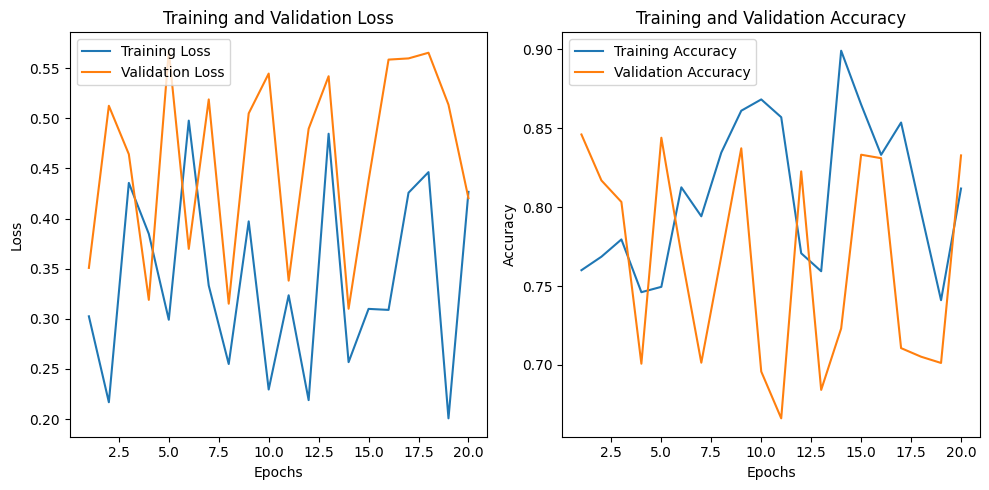

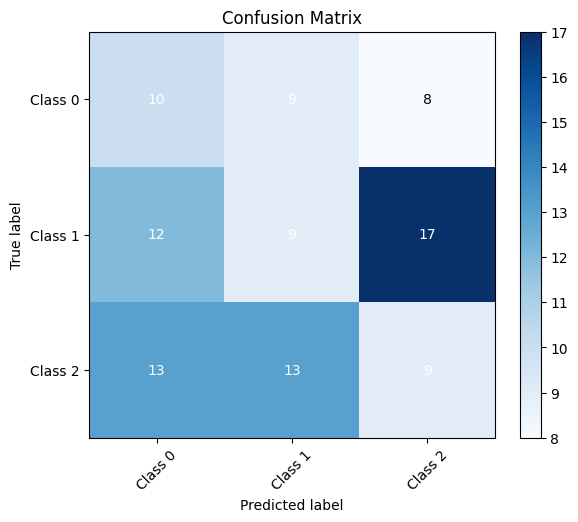

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Example data for training and validation curves
epochs = np.arange(1, 21)
training_loss = np.random.uniform(0.2, 0.5, len(epochs))
validation_loss = np.random.uniform(0.3, 0.6, len(epochs))
training_accuracy = np.random.uniform(0.7, 0.9, len(epochs))
validation_accuracy = np.random.uniform(0.65, 0.85, len(epochs))

# Example data for confusion matrix
y_true = np.random.randint(0, 3, 100)
y_pred = np.random.randint(0, 3, 100)
conf_matrix = confusion_matrix(y_true, y_pred)
labels = ['Class 0', 'Class 1', 'Class 2']

# Create training and validation curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Create confusion matrix heatmap
plt.figure(figsize=(6, 5))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             ha="center", va="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

